## Importing Libraries

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

## Device

In [2]:
# device setup
device = (
    "cuda:0" if torch.cuda.is_available() else # Nvidia GPU
    "mps" if torch.backends.mps.is_available() else # Apple Silicon GPU
    "cpu"
)
print(f"Device = {device}")

Device = cuda:0


## Dataset

In [3]:
# dataset path
dataset_path = 'data/'

# names dataset
names_dataset = dataset_path + 'names.txt'

# read the dataset
with open(names_dataset, 'r') as f:
    names_text = f.readlines()
    
# remove the new line character
names_text = [name.strip() for name in names_text]

In [4]:
# print the first 10 names
names_text[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

Number of names: 32033
Number of duplicates: 2539
Minimum Name Length: 2
Maximum Name Length: 15
Average Name Length: 6.122217712983486


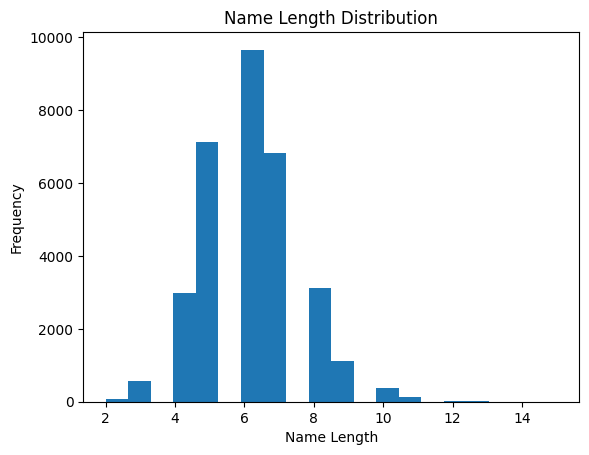

In [5]:
# number of names
print(f'Number of names: {len(names_text)}')

# check for duplicates
print(f'Number of duplicates: {len(names_text) - len(set(names_text))}')

# minimum name length
min_name_length = min([len(name) for name in names_text])
print(f'Minimum Name Length: {min_name_length}')

# maximum name length
max_name_length = max([len(name) for name in names_text])
print(f'Maximum Name Length: {max_name_length}')

# name length statistics
print(f'Average Name Length: {sum([len(name) for name in names_text]) / len(names_text)}')

# name length distribution
plt.hist([len(name) for name in names_text], bins=20)
plt.xlabel('Name Length')
plt.ylabel('Frequency')
plt.title('Name Length Distribution')
plt.show()

In [6]:
# number of unique characters
unique_chars = sorted(list(set(''.join(names_text))))
print(f'Number of Unique Characters: {len(unique_chars)}')

# unique characters
print(unique_chars)

Number of Unique Characters: 26
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Tokenization

In [7]:
# add special token
unique_chars = ['.', *unique_chars]

In [8]:
# create character to index mapping
char2idx = {char: idx for idx, char in enumerate(unique_chars)}
print(char2idx)

# create index to character mapping
idx2char = {idx: char for char, idx in char2idx.items()}
print(idx2char)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


## Hyperparameters

In [9]:
# dataset parameters
validation_split = 0.1

# training parameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

# model parameters
block_size = 3
vocab_size = len(unique_chars)
embedding_size = 64
hidden_size = 128

## Preprocessing

In [10]:
# add special token to names
names_text = [name + '.' for name in names_text]

In [11]:
# print the first 10 names
names_text[:10]

['emma.',
 'olivia.',
 'ava.',
 'isabella.',
 'sophia.',
 'charlotte.',
 'mia.',
 'amelia.',
 'harper.',
 'evelyn.']

In [12]:
# custom dataset: 3 characters -> 1 character
class NamesDataset(Dataset):
    def __init__(self, block_size):
        self.block_size = block_size
        self.data = []
        
        for name in names_text:
            context = [0] * self.block_size
            for char in name:
                idx = char2idx[char]
                self.data.append((context.copy(), idx))
                context = context[1:] + [idx]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X, Y = self.data[idx]
        return torch.tensor(X, dtype=torch.long), torch.tensor(Y, dtype=torch.long)

# create dataset
names_dataset = NamesDataset(block_size)

# validation split
val_size = int(validation_split * len(names_dataset))
train_size = len(names_dataset) - val_size
train_dataset, val_dataset = random_split(names_dataset, [train_size, val_size])

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# check the dataset
X, Y = names_dataset[0]
print(X.shape, Y.shape)

# check the dataloader
X, Y = next(iter(train_loader))
print(X.shape, Y.shape)

torch.Size([3]) torch.Size([])
torch.Size([64, 3]) torch.Size([64])


## Model

In [ ]:
class Linear:
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.randn(in_features, out_features) * (5/3) / ((in_features + out_features) ** 0.5)
        self.bias = torch.randn(out_features) * 0.01
        
    def forward(self, x):
        self.x = x
        return x @ self.weight + self.bias
    
    def backward(self, dy):
        self.dW = self.x.t() @ dy
        self.db = dy.sum(dim=0)
        dx = dy @ self.weight.t()
        return dx
    
    def update(self, lr):
        self.weight -= lr * self.dW
        self.bias -= lr * self.db

In [ ]:
class Tanh:
    def forward(self, x):
        self.x = x
        return torch.tanh(x)
    
    def backward(self, dy):
        return dy * (1 - self.x ** 2)

In [ ]:
class Softmax:
    def forward(self, x):
        exps = torch.exp(x)
        return exps / exps.sum(dim=-1, keepdim=True)
    
    def backward(self, dy):
        return dy

In [ ]:
class BatchNorm1d:
    def __init__(self, num_features):
        self.num_features = num_features
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        self.eps = 1e-5
        self.moving_mean = torch.zeros(num_features)
        self.moving_var = torch.ones(num_features)
        
    def forward(self, x, training=True):
        if training:
            mean = x.mean(dim=0)
            var = x.var(dim=0)
            x_hat = (x - mean) / torch.sqrt(var + self.eps)
            self.moving_mean = 0.9 * self.moving_mean + 0.1 * mean
            self.moving_var = 0.9 * self.moving_var + 0.1 * var
        else:
            x_hat = (x - self.moving_mean) / torch.sqrt(self.moving_var + self.eps)
        return self.gamma * x_hat + self.beta
    
    def backward(self, dy):
        m = dy.size(0)
        dx_hat = dy * self.gamma
        dgamma = (dy * self.x).sum(dim=0)
        dbeta = dy.sum(dim=0)
        dx = (m * dx_hat - dx_hat.sum(dim=0) - self.x * (dx_hat * self.x).sum(dim=0)) / (m * torch.sqrt(self.moving_var + self.eps))
        return dx, dgamma, dbeta

In [ ]:
class embedding:
    def __init__(self, vocab_size, embedding_size):
        self.embedding = torch.randn(vocab_size, embedding_size)
        
    def forward(self, x):
        return self.embedding[x]
    
    def backward(self, dy):
        dW = torch.zeros_like(self.embedding)
        dW[self.x] = dy
        return dW

In [14]:
"""
class MLP(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(MLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.fc1 = nn.Linear(embedding_size * block_size, hidden_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = F.tanh(self.fc1(x))
        x = self.batch_norm(x)
        x = self.fc2(x)
        return x
"""
class MLP():
    def __init__(self, vocab_size, embedding_size, hidden_size):
        self.embedding = embedding(vocab_size, embedding_size)
        self.fc1 = Linear(embedding_size * block_size, hidden_size)
        self.tanh = Tanh()
        self.fc2 = Linear(hidden_size, vocab_size)
        self.batch_norm = BatchNorm1d(hidden_size)
        self.softmax = Softmax()
        
    def forward(self, x):
        x = self.embedding.forward(x)
        self.x1 = self.fc1.forward(x)
        x = self.tanh.forward(self.x1)
        x = self.batch_norm.forward(x)
        self.x2 = self.fc2.forward(x)
        return self.softmax.forward(self.x2)
    
    def backward(self, dy):
        dy = self.softmax.backward(dy)
        dy = self.fc2.backward(dy)
        dy = self.batch_norm.backward(dy)
        dy = self.tanh.backward(dy)
        dy = self.fc1.backward(dy)
        return dy
    
    def update(self, lr):
        self.fc1.update(lr)
        self.fc2.update(lr)
        self.batch_norm.gamma -= lr * self.batch_norm.dgamma
        self.batch_norm.beta -= lr * self.batch_norm.dbeta
        
    def train(self, X, Y, lr):
        x = self.forward(X)
        loss = F.nll_loss(x, Y)
        dy = x.clone()
        dy[range(X.size(0)), Y] -= 1
        dy /= X.size(0)
        dy = self.backward(dy)
        self.update(lr)
        return loss
    
    def eval(self, X):
        return self.forward(X)
    
    def save(self, path):
        torch.save({
            'embedding': self.embedding.embedding,
            'fc1_weight': self.fc1.weight,
            'fc1_bias': self.fc1.bias,
            'fc2_weight': self.fc2.weight,
            'fc2_bias': self.fc2.bias,
            'gamma': self.batch_norm.gamma,
            'beta': self.batch_norm.beta,
            'moving_mean': self.batch_norm.moving_mean,
            'moving_var': self.batch_norm.moving_var
        }, path)
        
    def load(self, path):
        checkpoint = torch.load(path)
        self.embedding.embedding = checkpoint['embedding']
        self.fc1.weight = checkpoint['fc1_weight']
        self.fc1.bias = checkpoint['fc1_bias']
        self.fc2.weight = checkpoint['fc2_weight']
        self.fc2.bias = checkpoint['fc2_bias']
        self.batch_norm.gamma = checkpoint['gamma']
        self.batch_norm.beta = checkpoint['beta']
        self.batch_norm.moving_mean = checkpoint['moving_mean']
        self.batch_norm.moving_var = checkpoint['moving_var']
        
    def __call__(self, X):
        return self.forward(X)
    
model = MLP(vocab_size, embedding_size, hidden_size).to(device)
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

MLP(
  (embedding): Embedding(27, 64)
  (fc1): Linear(in_features=192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=27, bias=True)
)
Number of parameters: 29915


In [15]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## Initial Distribution

In [32]:
# activation distribution
model.eval()
X = next(iter(train_loader))
X = torch.tensor(X, dtype=torch.float)
output = model(X)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(F.tanh(model.fc1(X.view(X.size(0), -1))).cpu().detach().view(-1), bins=50)
plt.title('fc1 Activation Distribution')
plt.subplot(1, 2, 2)
plt.hist(model.fc2(output).cpu().detach().view(-1), bins=50)
plt.title('fc2 Activation Distribution')
plt.show()

ValueError: only one element tensors can be converted to Python scalars

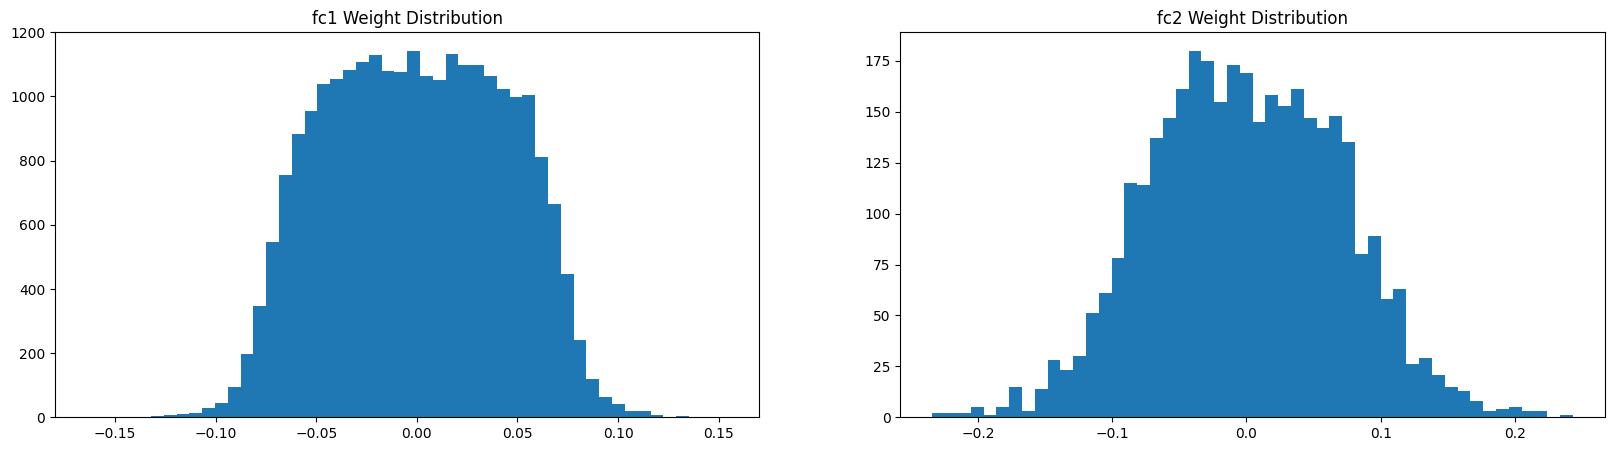

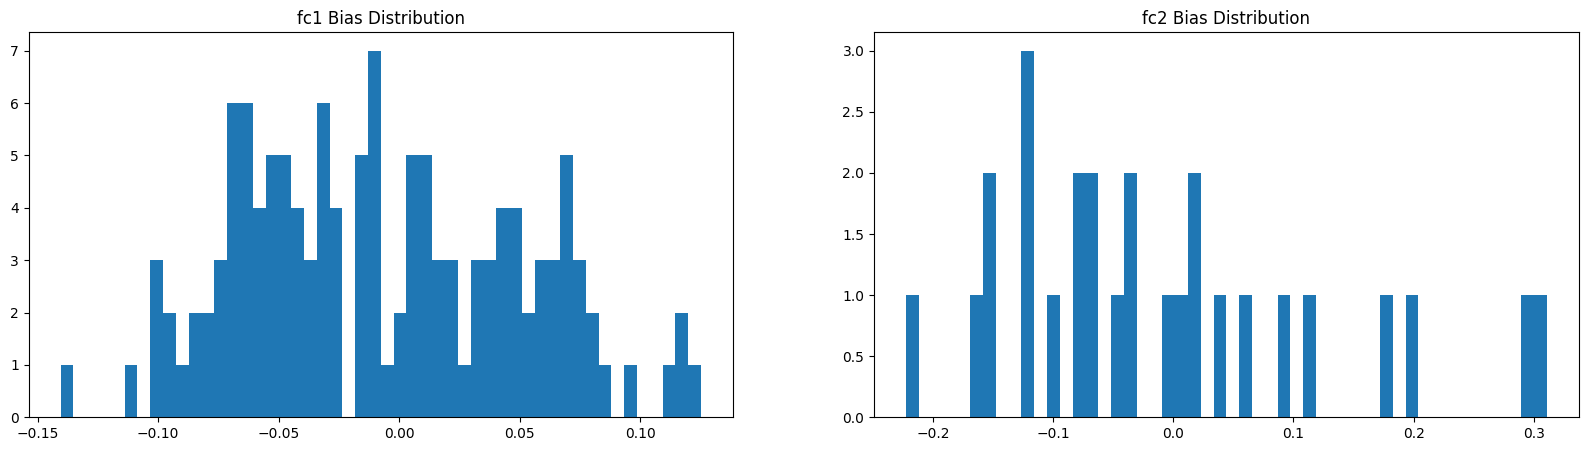

In [33]:
# weights&biases distribution
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(model.fc1.weight.cpu().detach().view(-1), bins=50)
plt.title('fc1 Weight Distribution')
plt.subplot(1, 2, 2)
plt.hist(model.fc2.weight.cpu().detach().view(-1), bins=50)
plt.title('fc2 Weight Distribution')
plt.show()

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(model.fc1.bias.cpu().detach().view(-1), bins=50)
plt.title('fc1 Bias Distribution')
plt.subplot(1, 2, 2)
plt.hist(model.fc2.bias.cpu().detach().view(-1), bins=50)
plt.title('fc2 Bias Distribution')
plt.show()

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

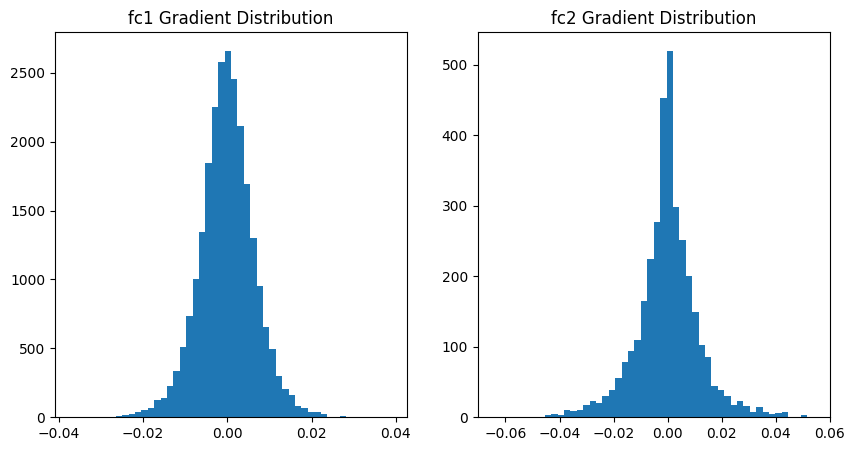

In [35]:
# gradient distribution
model.train()
X, Y = next(iter(train_loader))
X, Y = X.to(device), Y.to(device)
optimizer.zero_grad()
output = model(X)
loss = criterion(output, Y)
loss.backward()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(model.fc1.weight.grad.cpu().detach().view(-1), bins=50)
plt.title('fc1 Gradient Distribution')
plt.subplot(1, 2, 2)
plt.hist(model.fc2.weight.grad.cpu().detach().view(-1), bins=50)
plt.title('fc2 Gradient Distribution')
plt.show()

## Training

In [16]:
def train():
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X, Y in tqdm(train_loader):
            X, Y = X.to(device), Y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, Y in val_loader:
                X, Y = X.to(device), Y.to(device)
                output = model(X)
                loss = criterion(output, Y)
                val_loss += loss.item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

100%|██████████| 3209/3209 [00:03<00:00, 805.72it/s]


Epoch 1/10, Train Loss: 2.8778, Val Loss: 2.6590


100%|██████████| 3209/3209 [00:03<00:00, 850.88it/s]


Epoch 2/10, Train Loss: 2.5832, Val Loss: 2.5265


100%|██████████| 3209/3209 [00:04<00:00, 697.66it/s]


Epoch 3/10, Train Loss: 2.4936, Val Loss: 2.4642


100%|██████████| 3209/3209 [00:04<00:00, 735.79it/s]


Epoch 4/10, Train Loss: 2.4451, Val Loss: 2.4264


100%|██████████| 3209/3209 [00:04<00:00, 749.04it/s]


Epoch 5/10, Train Loss: 2.4134, Val Loss: 2.4008


100%|██████████| 3209/3209 [00:04<00:00, 728.30it/s]


Epoch 6/10, Train Loss: 2.3909, Val Loss: 2.3818


100%|██████████| 3209/3209 [00:04<00:00, 785.25it/s]


Epoch 7/10, Train Loss: 2.3735, Val Loss: 2.3670


100%|██████████| 3209/3209 [00:04<00:00, 738.18it/s]


Epoch 8/10, Train Loss: 2.3597, Val Loss: 2.3550


100%|██████████| 3209/3209 [00:04<00:00, 691.66it/s]


Epoch 9/10, Train Loss: 2.3482, Val Loss: 2.3448


100%|██████████| 3209/3209 [00:04<00:00, 787.02it/s]


Epoch 10/10, Train Loss: 2.3383, Val Loss: 2.3363


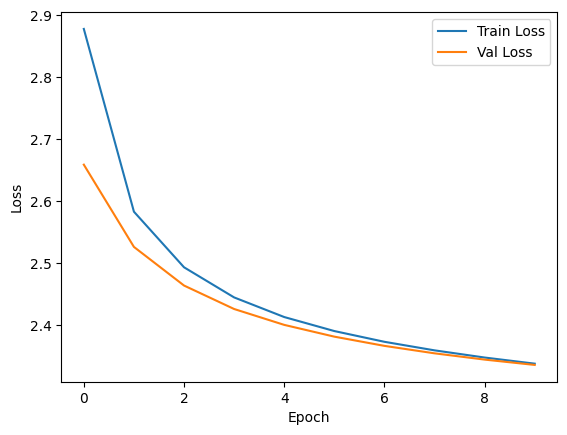

In [17]:
train()

In [18]:
# save the model
torch.save(model.state_dict(), 'model/mlp.pth')

## Distribution

RuntimeError: mat1 and mat2 must have the same dtype, but got Long and Float

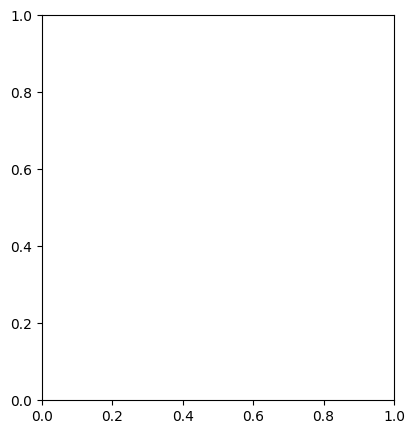

In [24]:
# activation distribution
model.eval()
X, Y = next(iter(train_loader))
X, Y = X.to(device), Y.to(device)
output = model(X)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(F.tanh(model.fc1(X.view(X.size(0), -1))).cpu().detach().view(-1), bins=50)
plt.title('fc1 Activation Distribution')
plt.subplot(1, 2, 2)
plt.hist(model.fc2(output).cpu().detach().view(-1), bins=50)
plt.title('fc2 Activation Distribution')
plt.show()

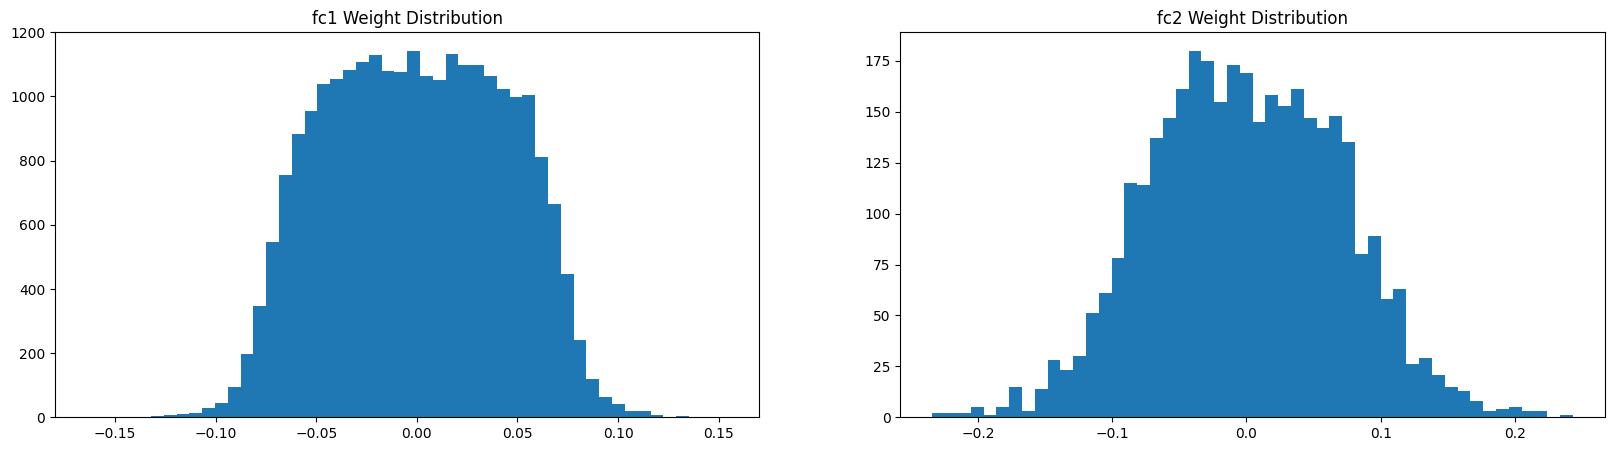

In [25]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(model.fc1.weight.cpu().detach().view(-1), bins=50)
plt.title('fc1 Weight Distribution')
plt.subplot(1, 2, 2)
plt.hist(model.fc2.weight.cpu().detach().view(-1), bins=50)
plt.title('fc2 Weight Distribution')
plt.show()

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(model.fc1.bias.cpu().detach().view(-1), bins=50)
plt.title('fc1 Bias Distribution')
plt.subplot(1, 2, 2)
plt.hist(model.fc2.bias.cpu().detach().view(-1), bins=50)
plt.title('fc2 Bias Distribution')
plt.show()

In [ ]:
# visualize the gradient distribution
model.train()
X, Y = next(iter(train_loader))
X, Y = X.to(device), Y.to(device)
optimizer.zero_grad()
output = model(X)
loss = criterion(output, Y)
loss.backward()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(model.fc1.weight.grad.detach().view(-1), bins=50)
plt.title('fc1 Gradient Distribution')
plt.subplot(1, 2, 2)
plt.hist(model.fc2.weight.grad.detach().view(-1), bins=50)
plt.title('fc2 Gradient Distribution')
plt.show()

## Inference

In [ ]:
def generate_name(max_length=20):
    model.eval()
    name = []
    with torch.no_grad():
        context = [0] * block_size
        for _ in range(max_length):
            X = torch.tensor(context, dtype=torch.long).unsqueeze(0).to(device)
            output = model(X)
            output = F.softmax(output, dim=-1)
            idx = torch.multinomial(output.view(-1), 1).item()
            if idx == 0:
                break
            name.append(idx2char[idx])
            context = context[1:] + [idx]
    return ''.join(name)

In [ ]:
# generate names
for _ in range(10):
    print(generate_name())

## No PYTORCH

In [ ]:
class MultiLayerPerceptron():
    def __init__(self, vocab_size, embedding_size, hidden_size):
        self.embedding = torch.randn(vocab_size, embedding_size)
        self.W1 = torch.randn(embedding_size * block_size, hidden_size) * (5/3) / ((embedding_size * block_size + hidden_size) ** 0.5)
        #self.b1 = torch.randn(hidden_size) * 0.01
        self.W2 = torch.randn(hidden_size, vocab_size) * 0.01
        self.b2 = torch.randn(vocab_size) * 0.01
        
        # batch normalization
        self.gamma = torch.ones(hidden_size)
        self.beta = torch.zeros(hidden_size)
        self.eps = 1e-5
        self.moving_mean = torch.zeros(hidden_size)
        self.moving_var = torch.ones(hidden_size)
    
    def batch_norm(self, x, training=True):
        if training:
            mean = x.mean(dim=0)
            var = x.var(dim=0)
            x_hat = (x - mean) / torch.sqrt(var + self.eps)
            self.moving_mean = 0.9 * self.moving_mean + 0.1 * mean
            self.moving_var = 0.9 * self.moving_var + 0.1 * var
        else:
            x_hat = (x - self.moving_mean) / torch.sqrt(self.moving_var + self.eps)
        return self.gamma * x_hat + self.beta
    
    def num_parameters(self):
        return self.embedding.numel() + self.W1.numel() + self.W2.numel() + self.b2.numel() + self.gamma.numel() + self.beta.numel() + self.moving_mean.numel() + self.moving_var.numel()
    
    def forward(self, x):
        x = self.embedding[x]
        x = x.view(x.size(0), -1)
        x = torch.tanh(x @ self.W1)
        x = x @ self.W2 + self.b2
        return x
    
    def backward(self, x, y, lr):
        m = x.size(0)
        y_hat = F.log_softmax(x, dim=-1)
        loss = F.nll_loss(y_hat, y)
        dy = y_hat.clone()
        dy[range(m), y] -= 1
        dy /= m
        dx = dy @ self.W2.t()
        dW2 = x.t() @ dy
        db2 = dy.sum(dim=0)
        dy = dy @ self.W2.t()
        dx = dx * (1 - x ** 2)
        dW1 = x.t() @ dx
        db1 = dx.sum(dim=0)
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        return loss
    
    def train(self, X, Y, lr):
        x = self.forward(X)
        return self.backward(x, Y, lr)
    
    def eval(self, X):
        return self.forward(X)
    
    def save(self, path):
        torch.save({
            'embedding': self.embedding,
            'W1': self.W1,
            'b1': self.b1,
            'W2': self.W2,
            'b2': self.b2,
            'gamma': self.gamma,
            'beta': self.beta,
            'moving_mean': self.moving_mean,
            'moving_var': self.moving_var
        }, path)
        
    def load(self, path):
        checkpoint = torch.load(path)
        self.embedding = checkpoint['embedding']
        self.W1 = checkpoint['W1']
        self.b1 = checkpoint['b1']
        self.W2 = checkpoint['W2']
        self.b2 = checkpoint['b2']
        self.gamma = checkpoint['gamma']
        self.beta = checkpoint['beta']
        self.moving_mean = checkpoint['moving_mean']
        self.moving_var = checkpoint['moving_var']
        
    def __call__(self, X):
        return self.forward(X)

In [ ]:
model = MultiLayerPerceptron(vocab_size, embedding_size, hidden_size)
print(model.num_parameters())

In [ ]:
# training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    for X, Y in tqdm(train_loader):
        X, Y = X, Y
        loss = model.train(X, Y, learning_rate)
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    val_loss = 0.0
    for X, Y in val_loader:
        X, Y = X, Y
        loss = model.train(X, Y, learning_rate)
        val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()